Midterm Project: Image Retrieval with Contrastive Learning

COMP 6831 – Applied Machine Learning, Fall 2025

Philippe Laporte 424172957

See the paper "Learning shallow convolutional feature descriptors with triplet losses" by V. Balntas, E. Riba et al. at https://bmva-archive.org.uk/bmvc/2016/papers/paper119/index.html


In [1]:
# --- Config ----

import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
import random
from torchvision import datasets, transforms, models
import torch
from collections import defaultdict
from PIL import Image
import os
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden.*")

torch.manual_seed(0)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Common code

In [ ]:
# --- SOPBaseDataset to load the Stanford Online product local data ---

# Data is stored as 
# image_id class_id super_class_id path
# For example:
# 747 125 1 bicycle_final/111085122871_0.JPG

# Note: we use "group" and "class" interchangeably

ROOT_DIR = 'data/stanford_online_products/'
TRAIN_ANNOTATION_FILE = 'Ebay_train.txt' 
TEST_ANNOTATION_FILE = 'Ebay_test.txt'

SUBSET_SIZE = 3000

class SOPBaseDataset(Dataset):
    """
    Base class for the Stanford Online Products dataset, handling file parsing
    """
    def __init__(self, root_dir, annotation_file, transform=None, max_samples=SUBSET_SIZE):
        self.root_dir = root_dir
        self.transform = transform
        
        # Load and parse the annotation file
        data = pd.read_csv(os.path.join(root_dir, annotation_file), sep=' ', skiprows=1, header=None)
        
        # Keep only the first max_samples entries
        if max_samples is not None and len(data) > max_samples:
            print(f"Trimming dataset from {len(data)} to {max_samples} samples.")
            data = data.head(max_samples)
        
        # Use columns for class_id (index 1) and path (index 3)
        self.image_paths = data.iloc[:, 3].apply(lambda x: os.path.join(root_dir, x)).tolist()
        self.labels = data.iloc[:, 1].values
        
        # Map class IDs to a continuous range starting from 0 
        unique_labels = np.unique(self.labels)
        self.label_map = {original_label: i for i, original_label in enumerate(unique_labels)}

        # Convert original labels to mapped, continuous labels
        self.labels = np.array([self.label_map[l] for l in self.labels])
        
        # Pre-process labels for fast triplet sampling
        self.label_to_indices = {label: np.where(self.labels == label)[0] 
                                 for label in np.unique(self.labels)}

        self.labels_set = np.unique(self.labels).tolist()

    def __len__(self):
        return len(self.image_paths) 

    def __getitem__(self, index):
        # 1. Load image from path
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert('RGB') # convert to pre-emptively uniformize the format expected by ResNet18
        
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label
    

VISUALIZATION_RANDOM_STATE = 0   

Part I 
Dataset Understanding

In [3]:
# --- Show image samples for a few classes ---

def display_image_samples(dataset, num_classes, num_per_class):
   
    _, axes = plt.subplots(num_per_class, num_classes, figsize=(2 * num_classes, 2 * num_per_class))
    
    sampled_labels = np.random.choice(dataset.labels_set, num_classes, replace=False)
    
    for i, mapped_label in enumerate(sampled_labels):
        indices = dataset.label_to_indices[mapped_label]
        
        # Sample images from this class
        sample_indices = np.random.choice(indices, num_per_class, replace=False)
        
        for j, data_index in enumerate(sample_indices):
            image, original_label = dataset[data_index]
            
            # Select the correct subplot axes
            ax = axes[j, i] if num_per_class > 1 else axes[i]
            
            ax.imshow(image)
            ax.set_title(f"Class: {original_label}", fontsize=8)
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Show statistics of the groups (classes) --- 

def show_dataset_statistics(dataset):
    
    # For easy counting
    labels_series = pd.Series(dataset.labels)
    
    total_samples = len(dataset)
    
    # Calculate class counts
    class_counts = labels_series.value_counts()
    total_classes = len(class_counts)
    
    print(f"Total Samples (Images): {total_samples}")
    print(f"Total Unique Mapped Classes: {total_classes}")
    print("-" * 35)
    
    print("Class Sample Counts (Basic):")
    print(f"  Min samples per class: {class_counts.min()}")
    print(f"  Max samples per class: {class_counts.max()}")
    print(f"  Mean samples per class: {class_counts.mean():.2f}")
    print(f"  Median samples per class: {class_counts.median()}")
    
    print("-" * 35)
    
    # Can't use classes with a single sample as triplet loss requires at least two samples per class (Anchor and Positive)
    classes_with_one_sample = (class_counts == 1).sum()
    
    valid_classes_for_triplet = (class_counts >= 2).sum()
    
    print("Triplet Loss Viability:")
    print(f"  Classes with < 2 samples: {classes_with_one_sample}")
    print(f"  Classes available for Triplet: {valid_classes_for_triplet}")

In [18]:
# --- Visualizes the data using t-SNE on features extracted from a fixed, pre-trained ResNet-18 --- 

def visualize_data_tsne_or_umap(dataset, tranformer_mixin, title):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1.DEFAULT)
    model = torch.nn.Sequential(*list(model.children())[:-1]) 
    model.to(device).eval()

    # Re-initialize dataset with full transform
    temp_dataset = dataset.__class__(
        root_dir=dataset.root_dir,
        annotation_file=TRAIN_ANNOTATION_FILE,
        transform=models.ResNet18_Weights.IMAGENET1K_V1.transforms(),
        max_samples=len(dataset)
    )
    feature_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)
    
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in feature_loader: 
            images = images.to(device)
            
            embeds = model(images).squeeze().cpu().detach().numpy() 
            
            embeddings.append(embeds)
            labels.append(batch_labels.numpy())

    full_embeddings = np.concatenate(embeddings)
    full_labels = np.concatenate(labels)
    
    X_embedding = tranformer_mixin.fit_transform(full_embeddings)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        X_embedding[:, 0], 
        X_embedding[:, 1], 
        c=full_labels, 
        cmap='Spectral', 
        s=15, 
        alpha=0.7
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    plt.colorbar(
        scatter, 
        label='Class Label',
        format=plt.FuncFormatter(lambda x, pos: f'ID {int(x)}')
    )
    
    plt.savefig(title + '.png', bbox_inches='tight')
    plt.show()

Trimming dataset from 59551 to 3000 samples.

--- Image Samples per Class ---


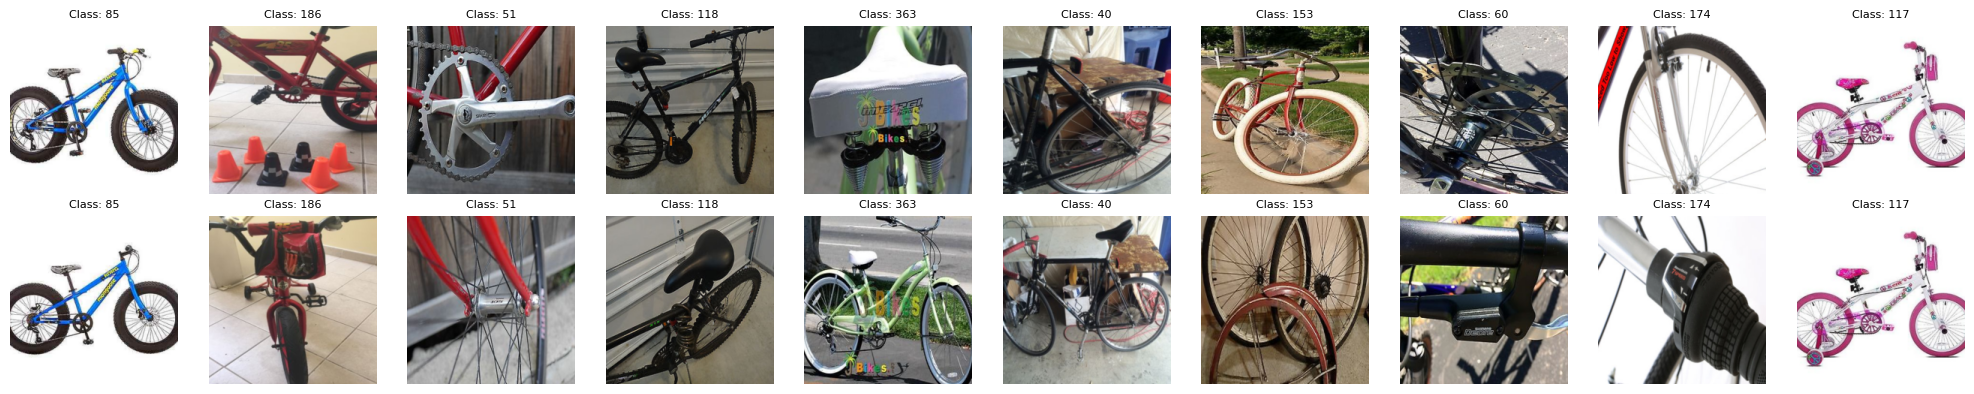


--- Dataset Statistics ---
Total Samples (Images): 3000
Total Unique Mapped Classes: 413
-----------------------------------
Class Sample Counts (Basic):
  Min samples per class: 2
  Max samples per class: 12
  Mean samples per class: 7.26
  Median samples per class: 7.0
-----------------------------------
Triplet Loss Viability:
  Classes with < 2 samples: 0
  Classes available for Triplet: 413

--- Pre-Training visualization ---

--- t-NSE ---
Trimming dataset from 59551 to 3000 samples.


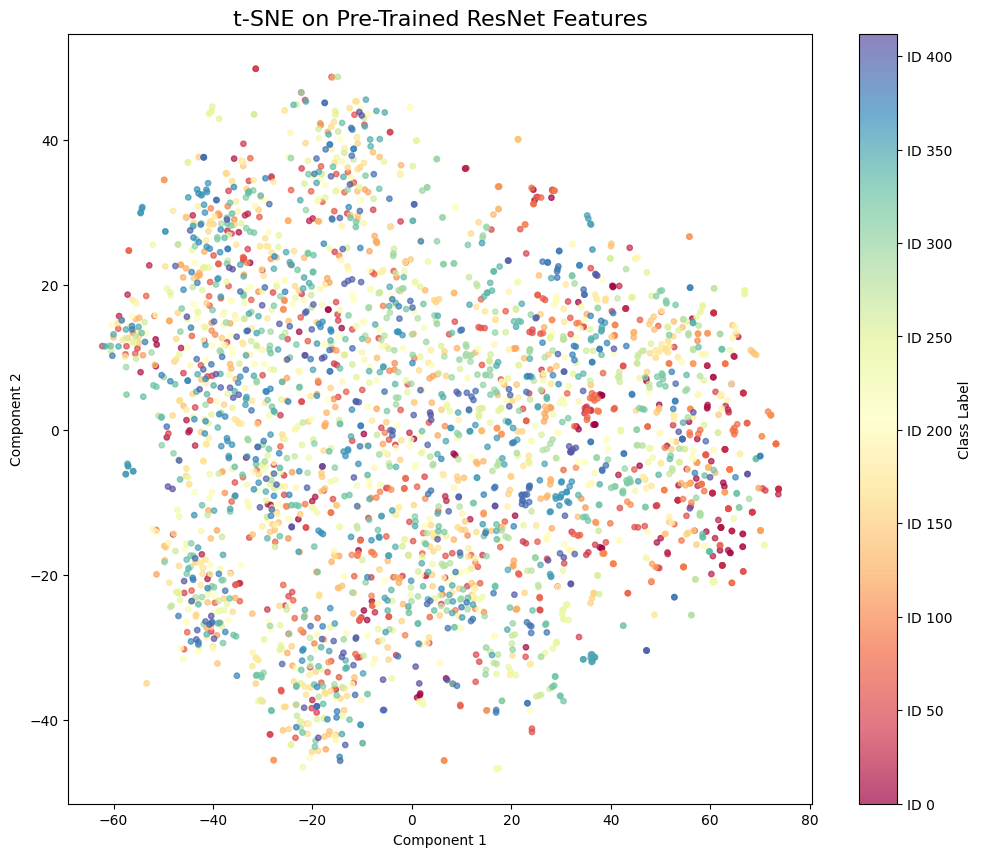


--- UMAP ---
Trimming dataset from 59551 to 3000 samples.


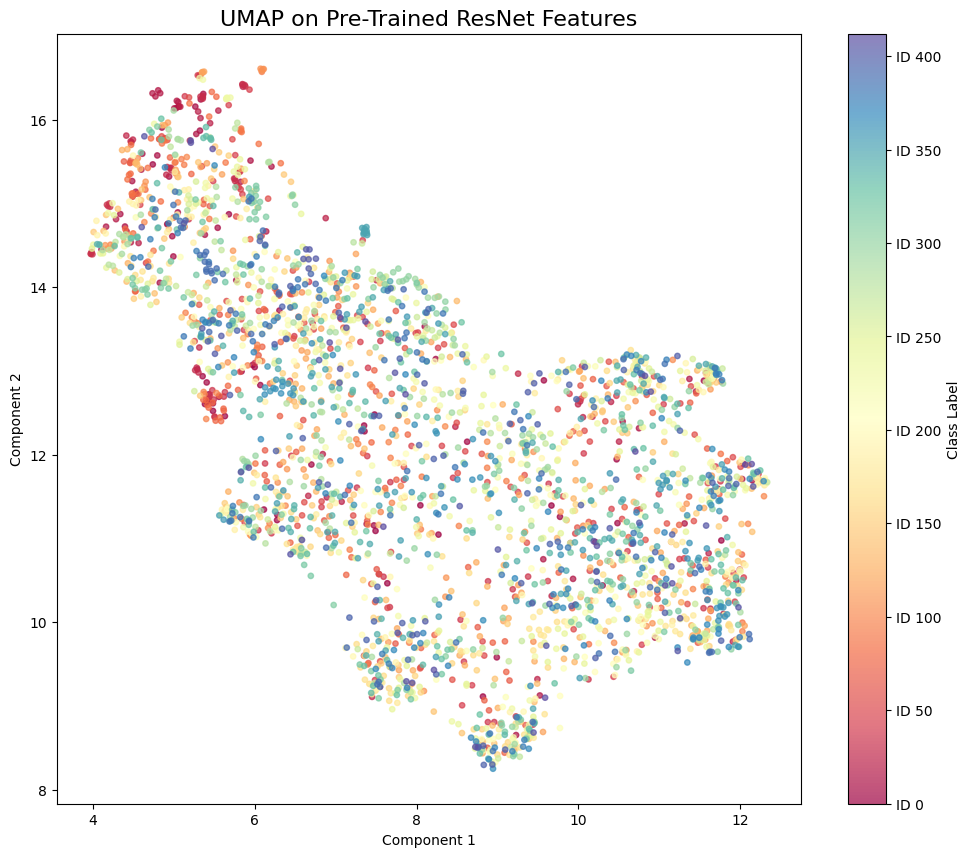

In [19]:
# --- Understanding driver ---

# Simple transform needed for image display, no normalization yet. See https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
UNDERSTANDING_TRANSFORM = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
])

sop_understand_data = SOPBaseDataset(
    root_dir=ROOT_DIR,
    annotation_file=TRAIN_ANNOTATION_FILE,
    transform=UNDERSTANDING_TRANSFORM,
    max_samples=SUBSET_SIZE
)

print("\n--- Image Samples per Class ---")
display_image_samples(sop_understand_data, num_classes=10, num_per_class=2)

print("\n--- Dataset Statistics ---")
show_dataset_statistics(sop_understand_data)
        
print("\n--- Pre-Training visualization ---") # Note: uses models.ResNet18_Weights.IMAGENET1K_V1.transforms()
print("\n--- t-NSE ---")
visualize_data_tsne_or_umap(sop_understand_data, TSNE(n_components=2, perplexity=30, n_iter_without_progress=100, random_state=VISUALIZATION_RANDOM_STATE), 't-SNE on Pre-Trained ResNet Features') # same parameters used post-training
print("\n--- UMAP ---")
visualize_data_tsne_or_umap(sop_understand_data, UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=VISUALIZATION_RANDOM_STATE), 'UMAP on Pre-Trained ResNet Features') # same parameters used post-training

Observations

- The data is eligible for the triplet data loss metric since there are no classes with less than 2 samples  
- No order yet in the data, no classifications seen in the visualizations, all data mixed together. Features from the generic ImageNet pre-training alone (without fine-tuning via Triplet Loss) are not sufficient to distinguish the fine-grained product categories in the dataset. The high-level features learned by ResNet-18 (e.g., "this is a shoe") are too general, proving that the metric learning fine-tuning step is essential to push the embeddings into a truly discriminative space.
- The ratio of Total Unique groups to Total Samples will be high (e.g., 1000 samples might contain 200+ unique groups). The Mean Samples per Class will likely be very low (e.g., 3-5).
  The dataset is highly sparse, meaning the model must learn to distinguish products with very few examples per groups. This justifies using a pretrained backbone (ResNet-18) to provide strong, generalized feature extraction
- Images within the same product group may exhibit significant differences due to varying backgrounds, lighting, camera angles, or even slight product variations (e.g., same shoe model in two different colors). The model needs to be invariant to spurious attributes (background, angle) and focus only on the core product features. This validates the use of Triplet Loss, which explicitly pushes for a small distance between these varied positive pairs.
- Images from different product classes (especially those within the same super-class, like two similar pairs of sunglasses) may look almost identical to the human eye. Observation: The task requires learning highly discriminative, subtle features. This confirms that standard classification loss would be ineffective, and the metric learning approach (Triplet Loss) is necessary to precisely separate these confusingly similar items.

In conclusion, The inherent noise and high dimensionality of the feature space demand a technique like Triplet Loss to enforce the required distance constraints and structure the feature space for successful retrieval.

Part II
Training and Evaluation pipeline

In [7]:
sop_train_data = SOPBaseDataset(root_dir=ROOT_DIR, annotation_file=TRAIN_ANNOTATION_FILE, transform=models.ResNet18_Weights.IMAGENET1K_V1.transforms())    
sop_test_data = SOPBaseDataset(root_dir=ROOT_DIR, annotation_file=TEST_ANNOTATION_FILE, transform=models.ResNet18_Weights.IMAGENET1K_V1.transforms())

Trimming dataset from 59551 to 3000 samples.
Trimming dataset from 60502 to 3000 samples.


In [ ]:
# --- Dataset and DataLoader for triplets, based on SOPBaseDataset ---

class TripletDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.label_to_indices = base_dataset.label_to_indices
        self.labels_set = base_dataset.labels_set

    def __len__(self):
        return len(self.base_dataset) 

    def __getitem__(self, index):
        anchor_img, anchor_label = self.base_dataset[index]
        
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.base_dataset[positive_index]
        
        negative_label = np.random.choice([l for l in self.labels_set if l != anchor_label])
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.base_dataset[negative_index]

        return anchor_img, positive_img, negative_img

In [ ]:
# --- Triplet Loader config ---

BATCH_SIZE = 64
NUM_WORKERS = 4

triplet_dataset = TripletDataset(sop_train_data)
triplet_loader = DataLoader(
    triplet_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [10]:
# --- Model: ResNet-18 Composer ---

class EmbeddingNet(torch.nn.Module):
    def __init__(self, embedding_dim):
        super(EmbeddingNet, self).__init__()
        
        # Load a pretrained ResNet-18 backbone like we did for the initial observations
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1.DEFAULT)
        # try resnet152, which is much deeper: my system runs out of memory
        #self.backbone = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
        
        # Set the final fully connected layer to output the embedding dimension.
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, embedding_dim)
        
    def forward(self, x):
        return self.backbone(x)

In [11]:
# --- Training ---

def train_model(model, loss_function, optimizer, dataloader, num_epoch):
    model.train()
    losses = []
    
    for epoch in range(1, num_epoch + 1):
        running_loss = 0.0
        
        for anchor, positive, negative in dataloader:
            # Move data to the correct device
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            embed_a = model(anchor)
            embed_p = model(positive)
            embed_n = model(negative)

            loss = loss_function(embed_a, embed_p, embed_n)
            
            # the usual
            optimizer.zero_grad()             
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * anchor.size(0)  # BATCH_SIZE

        # Calculate epoch statistics: average running_loss
        epoch_loss = running_loss / len(dataloader.dataset)
        losses.append(epoch_loss)
        
        print(f"Epoch {epoch}/{num_epoch} - Loss: {epoch_loss:.4f}")
        
    return losses

In [ ]:
# --- Plot training losses curve ---

def plot_training_loss(train_losses):

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='blue')
    plt.title('Training Curve (Loss vs. Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Triplet Loss')
    plt.grid(True)
    plt.savefig('training_loss.png', bbox_inches='tight')
    plt.show()

In [ ]:
# --- Embeddings ---

def get_embeddings_and_labels(model, dataset):

    embeddings = []
    labels = []
    
    # Use a standard DataLoader for generating embeddings, batch_size can be larger than before
    eval_loader = DataLoader(dataset, batch_size=256, shuffle=False)
    
    with torch.no_grad():
        for images, batch_labels in eval_loader:
            images = images.to(device)
            embeds = model(images).cpu().numpy()
            
            embeddings.append(embeds)
            labels.append(batch_labels.numpy())
            
    return np.concatenate(embeddings), np.concatenate(labels)

In [ ]:
# --- Precision@k ---

def calculate_precision_at_k(query_embeddings, query_labels, k):
    """Calculates Precision@k by comparing each query to all other items (acting as gallery)."""
    # Use the full set as both Query and Gallery (standard for metric learning evaluation)
    
    distances = euclidean_distances(query_embeddings, query_embeddings) 
    precision_k_list = []

    for i in range(len(query_embeddings)):
        # Exclude the query image itself from the results (index 0 might be itself)
        # Use argsort to get indices, then slice from index 1 (or handle self-retrieval)
        top_indices = np.argsort(distances[i])
        
        # Get the top K retrieved indices, excluding the query itself (index 0)
        top_k_indices = top_indices[1:k+1] 
        
        retrieved_labels = query_labels[top_k_indices]
        query_label = query_labels[i]
        
        # Count correct retrievals (labels matching the query)
        correct_retrievals = np.sum(retrieved_labels == query_label)
        precision_k_list.append(correct_retrievals / k)

    return np.mean(precision_k_list)

In [15]:
# --- Visualization of embeddings using t-SNE, UMAP or PCA ---

def visualize_embeddings(embeddings, labels, tranformer_mixin, title):
    X_embedding = tranformer_mixin.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_embedding[:, 0], X_embedding[:, 1], c=labels, cmap='Spectral', s=5)
    plt.colorbar(scatter, label='Class Label')
    plt.title(title, fontsize=16)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig(title + '.png', bbox_inches='tight')
    plt.show()

--- Starting Training ---
Epoch 1/50 - Loss: 0.2603
Epoch 2/50 - Loss: 0.1479
Epoch 3/50 - Loss: 0.1035
Epoch 4/50 - Loss: 0.0839
Epoch 5/50 - Loss: 0.0564
Epoch 6/50 - Loss: 0.0639
Epoch 7/50 - Loss: 0.0410
Epoch 8/50 - Loss: 0.0344
Epoch 9/50 - Loss: 0.0351
Epoch 10/50 - Loss: 0.0363
Epoch 11/50 - Loss: 0.0372
Epoch 12/50 - Loss: 0.0325
Epoch 13/50 - Loss: 0.0271
Epoch 14/50 - Loss: 0.0258
Epoch 15/50 - Loss: 0.0265
Epoch 16/50 - Loss: 0.0231
Epoch 17/50 - Loss: 0.0177
Epoch 18/50 - Loss: 0.0165
Epoch 19/50 - Loss: 0.0189
Epoch 20/50 - Loss: 0.0133
Epoch 21/50 - Loss: 0.0159
Epoch 22/50 - Loss: 0.0175
Epoch 23/50 - Loss: 0.0133
Epoch 24/50 - Loss: 0.0172
Epoch 25/50 - Loss: 0.0172
Epoch 26/50 - Loss: 0.0175
Epoch 27/50 - Loss: 0.0114
Epoch 28/50 - Loss: 0.0128
Epoch 29/50 - Loss: 0.0114
Epoch 30/50 - Loss: 0.0128
Epoch 31/50 - Loss: 0.0138
Epoch 32/50 - Loss: 0.0078
Epoch 33/50 - Loss: 0.0107
Epoch 34/50 - Loss: 0.0098
Epoch 35/50 - Loss: 0.0114
Epoch 36/50 - Loss: 0.0124
Epoch 37/50

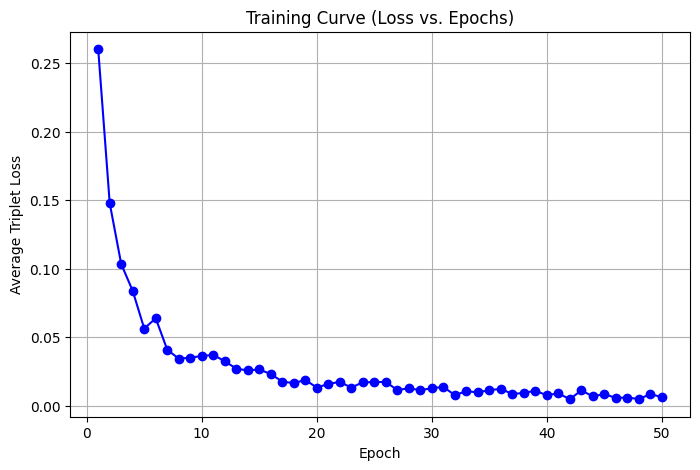


--- Starting Evaluation ---

--- Calculating Precision@k ---
Retrieval Results (Report): Precision@10 = 0.2622

--- Running t-SNE ---


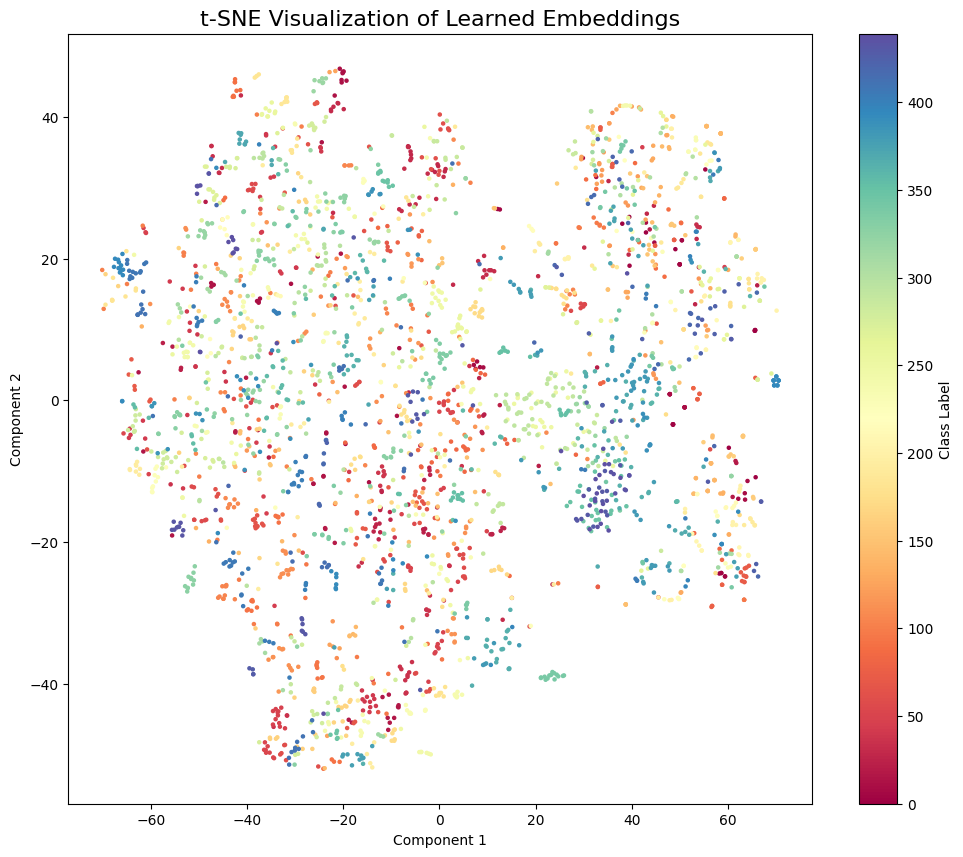


--- Running UMAP ---


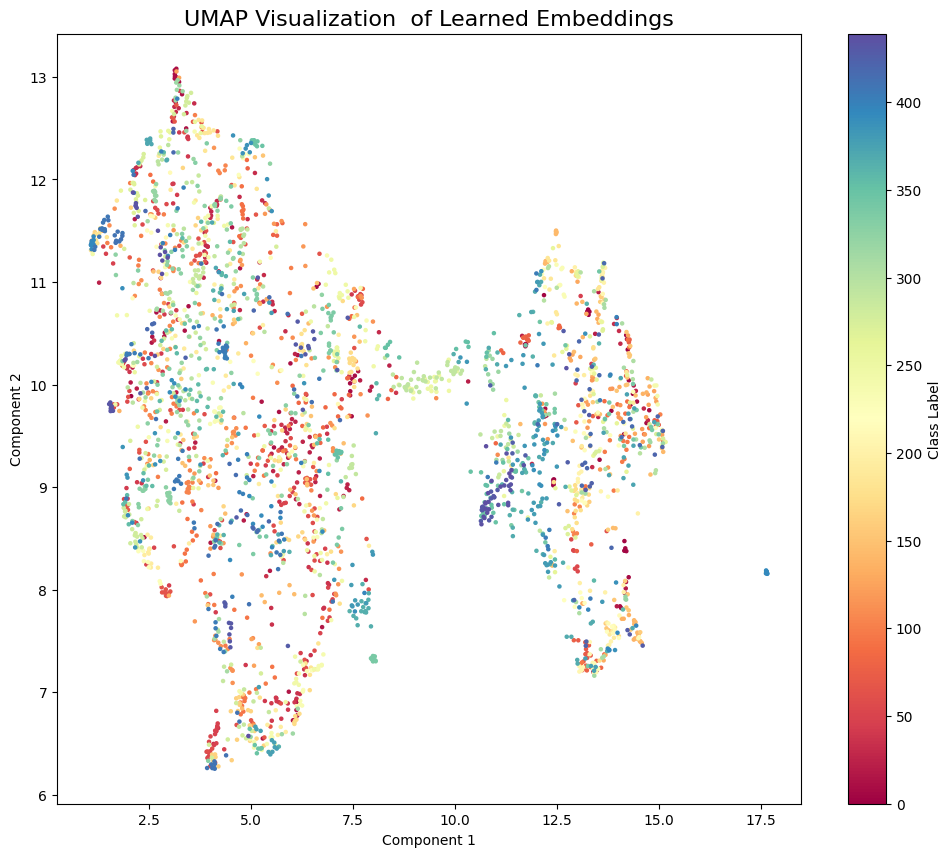


--- Running PCA ---


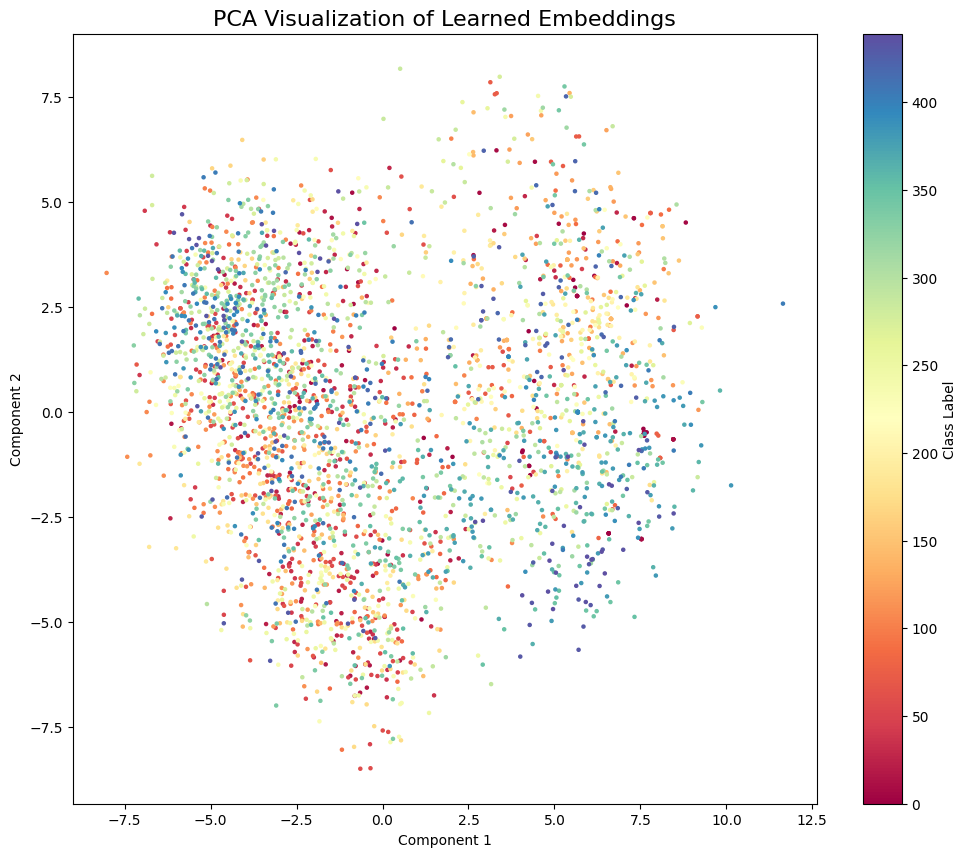

In [ ]:
# --- Pipeline ---

MARGIN = 1.0 
LR = 0.05
NUM_EPOCH = 50
EMBEDDING_DIM = 128
K_PRECISION = 10

model = EmbeddingNet(embedding_dim=EMBEDDING_DIM).to(device)
loss_function = torch.nn.TripletMarginLoss(margin=MARGIN)
optimizer = torch.optim.SGD(model.parameters(), lr=LR) 

print("--- Starting Training ---")
model.train()
training_history = train_model(model, loss_function, optimizer, triplet_loader, NUM_EPOCH)

plot_training_loss(training_history)

print("\n--- Starting Evaluation ---")
model.eval()
# Get embeddings for the test set
eval_embeddings, eval_labels = get_embeddings_and_labels(model, sop_test_data)

print("\n--- Calculating Precision@k ---")
precision_k = calculate_precision_at_k(eval_embeddings, eval_labels, K_PRECISION)
print(f"Retrieval Results (Report): Precision@{K_PRECISION} = {precision_k:.4f}")
    
# Visualization
print("\n--- Running t-SNE ---")
visualize_embeddings(eval_embeddings, eval_labels, TSNE(n_components=2, perplexity=30, n_iter_without_progress=100, random_state=VISUALIZATION_RANDOM_STATE), 't-SNE Visualization of Learned Embeddings') 

print("\n--- Running UMAP ---")
visualize_embeddings(eval_embeddings, eval_labels, UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=VISUALIZATION_RANDOM_STATE), 'UMAP Visualization  of Learned Embeddings') 

print("\n--- Running PCA ---")
visualize_embeddings(eval_embeddings, eval_labels, PCA(n_components=2, random_state=VISUALIZATION_RANDOM_STATE), 'PCA Visualization of Learned Embeddings') 